In [2]:
import pandas as pd
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
from scipy import stats
from collections import defaultdict
import csv
import seaborn as sns

In [3]:
players = pd.read_csv('./data/players.csv')
games = pd.read_csv('./data/games.csv')
plays = pd.read_csv('./data/plays.csv')

In [4]:
def mapIdToName(id):
    return players[players['nflId'] == id].iloc[0].displayName

In [5]:
def getClosest(players, football):
    distances = []
    for index, row in players.iterrows():
        distance = np.linalg.norm(np.subtract([football.x.values[0], football.y.values[0]], [row.x, row.y]))
        distances.append((row.nflId, distance))
    closest = sorted(distances, key= lambda t: t[1])[0][0]
    return closest

In [6]:
average_yac = defaultdict(list)
total_catches = defaultdict(int)

In [7]:
for week_num in range(1, 18):
    print(week_num)
    g_week = games[games['week'] == week_num]
    week_str = './data/week' + str(week_num) + '.csv'
    current_week_data = pd.read_csv(week_str)
    
    for _, g_row in g_week.iterrows():
        GAMEID = g_row.gameId
        cwg_data = current_week_data[current_week_data['gameId'] == GAMEID]
        pg = plays[plays['gameId'] == GAMEID]
        
        for PLAY in pg.playId:
            curr_play_data = cwg_data[cwg_data['playId'] == PLAY]
            
            play_events = pd.unique(curr_play_data.event)
            if 'first_contact' in play_events:
                try:
                    OFFENSIVE_TEAM = curr_play_data[curr_play_data['position'] == 'QB'].team.values[0]
                except:
                    continue

                first_contact_data = curr_play_data[curr_play_data['event'] == 'first_contact']
                football1 = first_contact_data[first_contact_data['team'] == 'football']
                offensive_players = first_contact_data[first_contact_data['team'] == OFFENSIVE_TEAM]
                try:
                    closest1 = getClosest(offensive_players, football1)
                    total_catches[closest1] += 1
                    x1 = offensive_players[offensive_players['nflId'] == closest1].x.values[0]
                except:
                    continue
                
                END_EVENT = ''
                if 'tackle' in play_events:
                    END_EVENT = 'tackle'
                elif 'out_of_bounds' in play_events:
                    END_EVENT = 'out_of_bounds'
                else:
                    continue
                    
                end_data = curr_play_data[curr_play_data['event'] == END_EVENT]
                try:
                    x2 = end_data[end_data['nflId'] == closest1].x.values[0]
                except:
#                     print(END_EVENT, closest1)
#                     print(end_data)
                    continue

                if end_data.playDirection.values[0] == 'left':
                    yards = x1 - x2
                elif end_data.playDirection.values[0] == 'right':
                    yards = x2 - x1
                else:
                    print('No direction?')

                average_yac[closest1].append(yards if yards > 0 else 0)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [8]:
receiver_avg = {k: np.sum(v) / len(v) for k,v in average_yac.items()}
readable_dict = {mapIdToName(k): v for k,v in receiver_avg.items()}
sorted(readable_dict.items(), key=lambda t: t[1], reverse=True)[:50]

[('Jeff Driskel', 12.99),
 ('Darren Waller', 10.634999999999998),
 ('Derrick Willies', 10.01),
 ('Eric Tomlinson', 7.923999999999997),
 ('Frank Gore', 7.531428571428571),
 ('Patrick DiMarco', 6.890000000000001),
 ('Adrian Peterson', 6.821428571428574),
 ('Chase Daniel', 6.740000000000009),
 ('Ed Dickson', 6.4875000000000025),
 ('D.J. Moore', 6.3475),
 ("De'Anthony Thomas", 6.344999999999999),
 ('Dontrell Hilliard', 6.321428571428572),
 ('Jordan Akins', 6.177499999999999),
 ('Jalen Tolliver', 6.150000000000006),
 ('Chris Ivory', 6.043333333333332),
 ('Mo Alie-Cox', 6.027500000000002),
 ('A.J. Derby', 5.980000000000004),
 ('Jermaine Gresham', 5.643750000000001),
 ('David Moore', 5.591999999999999),
 ('Richie James', 5.529999999999997),
 ('Sammie Coates', 5.459999999999994),
 ('Isaiah Crowell', 5.456111111111111),
 ('Brandon Marshall', 5.25),
 ('DeAndre Washington', 5.200000000000003),
 ('Zach Zenner', 5.160000000000001),
 ('Allen Robinson', 5.040434782608695),
 ('Will Dissly', 5.01000000

In [9]:
with open('receiver_ability.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    writer.writerow(['nflId', 'score'])
    for key, value in receiver_avg.items():
       writer.writerow([key, value])

In [15]:
MAX_CATCHES = max(total_catches.values())
receiver_avg_scaled = {k: ((np.sum(v) / len(v))) * ((total_catches.get(k, 0) / MAX_CATCHES)) for k,v in average_yac.items()}
readable_dict = {mapIdToName(k): v for k,v in receiver_avg_scaled.items()}
best = sorted(readable_dict.items(), key=lambda t: t[1], reverse=True)[:15]
best

[('Christian McCaffrey', 3.9537907137907133),
 ('Saquon Barkley', 3.3735897435897435),
 ('George Kittle', 3.294487179487179),
 ('D.J. Moore', 3.0109935897435895),
 ('Michael Thomas', 2.839358974358975),
 ('James Conner', 2.8149019607843133),
 ('Alvin Kamara', 2.6751373626373622),
 ('Golden Tate', 2.632435897435899),
 ('Travis Kelce', 2.4575641025641017),
 ('Ezekiel Elliott', 2.3436785009861927),
 ('Jalen Richard', 2.2131297134238315),
 ('Vance McDonald', 2.0828205128205126),
 ('JuJu Smith-Schuster', 2.0590666666666664),
 ('Willie Snead', 1.9869230769230766),
 ('Kenny Golladay', 1.9313186813186818)]

In [11]:
with open('receiver_ability_scaled.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    writer.writerow(['nflId', 'receiver_score'])
    for key, value in receiver_avg_scaled.items():
       writer.writerow([key, value])

In [17]:
br = {}
for t in best:
    br[t[0]] = t[1]
df = pd.DataFrame.from_dict(br, orient='index')
df.reset_index(level=0, inplace=True)
df = df.rename(columns={"index": "name", 0: "score"})
df

,name,score
0,Christian McCaffrey,3.953791
1,Saquon Barkley,3.373590
2,George Kittle,3.294487
3,D.J. Moore,3.010994
4,Michael Thomas,2.839359
5,James Conner,2.814902
6,Alvin Kamara,2.675137
7,Golden Tate,2.632436
8,Travis Kelce,2.457564
9,Ezekiel Elliott,2.343679


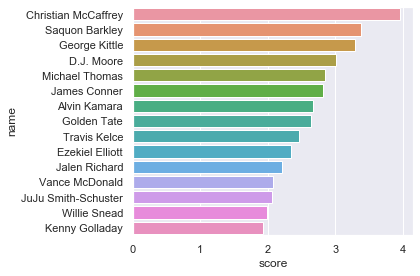

In [18]:
sns.set_theme(style='darkgrid')
ax = sns.barplot(x='score', y='name', data=df)
ax.figure.tight_layout()
ax.figure.savefig('rec_graph.png')